In [2]:
import os
from ae_functions import get_folder_pickle_files
from load_data import *
import matplotlib.pyplot as plt
from ae_functions import *
from torch.utils.data import DataLoader
import numpy as np
from acoustic_emission_dataset import AcousticEmissionDataset

# Load AE Dataset

In [3]:
# SIGNAL PROCESSING CONSTANTS
SIG_LEN = 1024           # [samples / signal] ;
DT = 10**-7              # [seconds] ; sample period / time between samples
LOW_PASS = 50*10**3      # [Hz] ; low frequency cutoff
HIGH_PASS = 800*10**3    # [Hz] ; high frequency cutoff
FFT_UNITS = 1000         # FFT outputs in Hz, this converts to kHz
NUM_BINS = 26            # For partial power

# FILE I/O
JSON_DATA_FILE = 'C:/Users/tul72/Desktop/phd/projects/pencil_lead_breaks/Data/PLB_data.json'

# Load AE data
ae_dataset = AcousticEmissionDataset(JSON_DATA_FILE,SIG_LEN,DT,LOW_PASS,
                                     HIGH_PASS,FFT_UNITS,NUM_BINS,0,0)

angles = ae_dataset.angles # what the one hot encoded targets map to
num_classes = len(angles)  # how many diff angles, for model output dim
example_feature_vec, _ = ae_dataset[0] # to determine feature dim
feature_dim = example_feature_vec.shape[0] # for model creation input dim

targets_num is the angle. ex: 20.0 or 40.0
targets_one_hot is the one hot encoding for angle. ex: [1 0 1]

Shape of waves is: torch.Size([847, 1024])
Datatype of waves is: torch.float32
waves requires grad: False
Shape of targets is: torch.Size([847])
Datatype of targets is: torch.int64
targets requires grad: False
Ex: 0
Shape of targets_num is: torch.Size([847])
Datatype of targets_num is: torch.float32
targets_num requires grad: False
Ex: 20.0
Shape of targets_one_hot is: torch.Size([847, 5])
Datatype of targets_one_hot is: torch.float32
targets_one_hot requires grad: False
Ex: tensor([1, 0, 0, 0, 0])

AcousticEmissionDataset loaded in!



# Load Experimental Data

In [19]:
EXPERIMENT = 3
data=load_experiment_results(EXPERIMENT)

Retrieved data (1 pickle files) from C:\Users\tul72\Desktop\phd\projects\pencil_lead_breaks\supervised_learning\nn_regression/experiment_03/


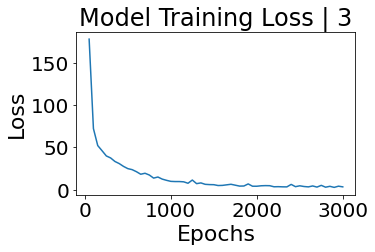

In [20]:
x = np.linspace(0,data['EPOCHS'],int(data['EPOCHS']/50)+1)

create_figure('', 1, 1, width=5, height=3,
                  suptitle_font_size=20, default_font_size=10,
                  title_font_size=24, axes_font_size=22, tick_font_size=20,
                  legend_font_size=10, w_space=0.25, h_space=0.25)

plt.plot(x[1:],data['Loss'][1:])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Model Training Loss | {EXPERIMENT}')
plt.show()

# Load Trained Model

In [21]:
pth_path = './experiment_03/nn01_3000_0.001_adam_mse.pth'
model_num = 2
feature_dim = 1024
model = load_model(pth_path, model_num, feature_dim)

NeuralNetwork_02(
  (layers): Sequential(
    (0): Linear(in_features=1024, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)


# Evaluated Trained Model on Waveforms of Specific Angle

In [22]:
test_angles = ['40deg']
test_data = ae_dataset._get_angle_subset(test_angles)
test_data_loader = DataLoader(test_data)
len(test_data)

146

In [23]:
model.eval()
with torch.no_grad():
    test_predicted = []
    for inputs, targets in test_data_loader: # loop through all examples
        prediction = model(inputs)  # trained model prediction
        test_predicted.append(prediction.numpy()) # save prediction
        
test_predicted = np.array(test_predicted)
test_predicted = test_predicted.flatten()

# Visualize Predictions

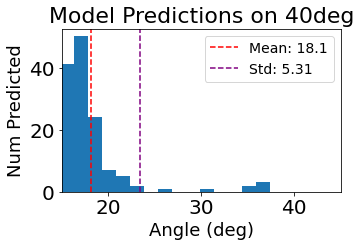

In [24]:
create_figure('', 1, 1, width=5, height=3,
                  suptitle_font_size=18, default_font_size=10,
                  title_font_size=22, axes_font_size=18, tick_font_size=20,
                  legend_font_size=14, w_space=0.25, h_space=0.25)

mean = test_predicted.mean()
std = test_predicted.std()
plt.hist(test_predicted,bins=30)
plt.axvline(test_predicted.mean(),color='red',linestyle='--',label=f'Mean: {mean:.3g}')
plt.axvline(mean+std,color='purple',linestyle='--',label=f'Std: {std:.3g}')
plt.axvline(mean-std,color='purple',linestyle='--')
plt.ylabel('Num Predicted')
plt.xlabel('Angle (deg)')
plt.xlim([15, 45])
plt.title(f'Model Predictions on {test_angles[0]}')
plt.legend()
plt.show()